# How to pass config to tools

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
        This guide assumes familiarity with the following:
        <ul>
            <li>
                <a href="https://python.langchain.com/docs/concepts/#runnable-interface">
                    Runnable Interface
                </a>
            </li>
            <li>
                <a href=" https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#tool-calling-agent">
                    Tool calling agent
                </a>
            </li>      
            <li>
                <a href="https://python.langchain.com/docs/concepts/#tools">
                    Tools
                </a>
            </li>
            <li>
                <a href="https://langchain-ai.github.io/langgraph/concepts/streaming/">
                    Streaming
                </a>
            </li>            
            <li>
                <a href="https://python.langchain.com/docs/concepts/#chat-models/">
                    Chat Models
                </a>
            </li>
        </ul>
    </p>
</div> 



At runtime, you may need to pass values to a tool, like a user ID, which should be set by the application logic, not controlled by the LLM, for security reasons. The LLM should only manage its intended parameters.

LangChain tools use the `Runnable` interface, where methods like `invoke` accept runtime information through the `RunnableConfig` argument.

In the following example, we’ll set up an agent with tools to manage a user's favorite pets—adding, reading, and deleting entries—while fixing the user ID through application logic and letting the chat model control other parameters

## Setup

First, let's install the required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Define tools and model

In [3]:
from typing import List

from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig

from langgraph.prebuilt import ToolNode

user_to_pets = {}


@tool(parse_docstring=True)
def update_favorite_pets(
    # NOTE: config arg does not need to be added to docstring, as we don't want it to be included in the function signature attached to the LLM
    pets: List[str],
    config: RunnableConfig,
) -> None:
    """Add the list of favorite pets.

    Args:
        pets: List of favorite pets to set.
    """
    user_id = config.get("configurable", {}).get("user_id")
    user_to_pets[user_id] = pets


@tool
def delete_favorite_pets(config: RunnableConfig) -> None:
    """Delete the list of favorite pets."""
    user_id = config.get("configurable", {}).get("user_id")
    if user_id in user_to_pets:
        del user_to_pets[user_id]


@tool
def list_favorite_pets(config: RunnableConfig) -> None:
    """List favorite pets if any."""
    user_id = config.get("configurable", {}).get("user_id")
    return ", ".join(user_to_pets.get(user_id, []))

In [4]:
tools = [update_favorite_pets, delete_favorite_pets, list_favorite_pets]
tool_node = ToolNode(tools)

We'll be using a small chat model from Anthropic in our example. To use chat models with tool calling, we need to first ensure that the model is aware of the available tools. We do this by calling `.bind_tools` method on `ChatAnthropic` moodel

In [5]:
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


model_with_tools = ChatAnthropic(
    model="claude-3-haiku-20240307", temperature=0
).bind_tools(tools)

## ReAct Agent

Let's set up a graph implementation of the [ReAct agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent). This agent takes some query as input, then repeatedly call tools until it has enough information to resolve the query. We'll be using prebuilt `ToolNode` and the Anthropic model with tools we just defined.

In [6]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


builder = StateGraph(MessagesState)

# Define the two nodes we will cycle between
builder.add_node("agent", call_model)
builder.add_node("tools", tool_node)

builder.add_edge(START, "agent")
builder.add_conditional_edges("agent", should_continue, ["tools", END])
builder.add_edge("tools", "agent")

graph = builder.compile()

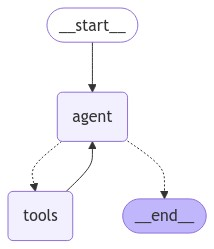

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use it!

In [8]:
from langchain_core.messages import HumanMessage

user_to_pets.clear()  # Clear the state

print(f"User information prior to run: {user_to_pets}")

inputs = {"messages": [HumanMessage(content="my favorite pets are cats and dogs")]}
for chunk in graph.stream(
    inputs, {"configurable": {"user_id": "123"}}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

print(f"User information after the run: {user_to_pets}")

User information prior to run: {}
================================ Human Message =================================

my favorite pets are cats and dogs
================================== Ai Message ==================================

[{'text': "Okay, let's update your favorite pets:", 'type': 'text'}, {'id': 'toolu_01SU6vhbKDjSsPj2z86QA3wy', 'input': {'pets': ['cats', 'dogs']}, 'name': 'update_favorite_pets', 'type': 'tool_use'}]
Tool Calls:
  update_favorite_pets (toolu_01SU6vhbKDjSsPj2z86QA3wy)
 Call ID: toolu_01SU6vhbKDjSsPj2z86QA3wy
  Args:
    pets: ['cats', 'dogs']
================================= Tool Message =================================
Name: update_favorite_pets

null
================================== Ai Message ==================================

Your favorite pets have been updated to cats and dogs.
User information after the run: {'123': ['cats', 'dogs']}


In [9]:
from langchain_core.messages import HumanMessage

print(f"User information prior to run: {user_to_pets}")

inputs = {"messages": [HumanMessage(content="what are my favorite pets")]}
for chunk in graph.stream(
    inputs, {"configurable": {"user_id": "123"}}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

print(f"User information prior to run: {user_to_pets}")

User information prior to run: {'123': ['cats', 'dogs']}
================================ Human Message =================================

what are my favorite pets
================================== Ai Message ==================================

[{'id': 'toolu_01DdpiqiCxzbR4RjQdEoR6mJ', 'input': {}, 'name': 'list_favorite_pets', 'type': 'tool_use'}]
Tool Calls:
  list_favorite_pets (toolu_01DdpiqiCxzbR4RjQdEoR6mJ)
 Call ID: toolu_01DdpiqiCxzbR4RjQdEoR6mJ
  Args:
================================= Tool Message =================================
Name: list_favorite_pets

cats, dogs
================================== Ai Message ==================================

Based on the list_favorite_pets tool, your favorite pets are cats and dogs.
User information prior to run: {'123': ['cats', 'dogs']}


In [10]:
print(f"User information prior to run: {user_to_pets}")

inputs = {
    "messages": [
        HumanMessage(content="please forget what i told you about my favorite animals")
    ]
}
for chunk in graph.stream(
    inputs, {"configurable": {"user_id": "123"}}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

print(f"User information prior to run: {user_to_pets}")

User information prior to run: {'123': ['cats', 'dogs']}
================================ Human Message =================================

please forget what i told you about my favorite animals
================================== Ai Message ==================================

[{'id': 'toolu_013TXG6yTxvuWiugbdKGTKSF', 'input': {}, 'name': 'delete_favorite_pets', 'type': 'tool_use'}]
Tool Calls:
  delete_favorite_pets (toolu_013TXG6yTxvuWiugbdKGTKSF)
 Call ID: toolu_013TXG6yTxvuWiugbdKGTKSF
  Args:
================================= Tool Message =================================
Name: delete_favorite_pets

null
================================== Ai Message ==================================

I have deleted the information about your favorite pets. The list of favorite pets has been cleared.
User information prior to run: {}
